# Import and reading

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import math
import warnings
from torch.optim.lr_scheduler import CosineAnnealingLR
from scipy import stats
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# !python -m wget -o data.text.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [4]:
df = pd.read_csv('data.text.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

# Ridge and Constant models

In [6]:
#Осткалируем все данные
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
#Функция фиксации сида
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

#Вссегда будем применять main_random_seed
main_random_state = 42

In [8]:
#Обычный линрег с L2
model_ridge = Ridge(random_state=main_random_state)
model_ridge.fit(X_train, y_train)

Ridge(random_state=42)

In [9]:
#Создадим массив с метриками, полученными на Ridge и Constsnt моедли
result_ridge_train = root_mean_squared_error(y_train, model_ridge.predict(X_train))
result_ridge_test = root_mean_squared_error(y_test, model_ridge.predict(X_test))

result_constant_train = root_mean_squared_error(y_train, np.full(shape=y_train.shape[0], fill_value=y_train.mean()))
result_constant_test = root_mean_squared_error(y_train, np.full(shape=y_train.shape[0], fill_value=y_test.mean()))

In [10]:
#Выведем таблицу
result = pd.DataFrame([[result_ridge_train, result_ridge_test],
                       [result_constant_train, result_constant_test]],
                      columns=['Train', 'Test'], index=['Ridge', 'Constant'])

result

,Train,Test
Ridge,9.552823,9.510161
Constant,10.939755,10.940305


Как видим, результаты Ridge регрессии на наших данных лучше (что неудивительно), но они все равно неидеальны

# Ex. 1 Linear Regression with nn.Linear

In [11]:
class OneLinearLayer(nn.Module):
    def __init__(self, random_state=42):
        #Вызовем конструктор родилтеля, установим сиды
        #и объявим, что будет слой
        super(OneLinearLayer, self).__init__()
        set_random_seed(random_state)
        self.layer = None

    def forward(self, X):
        #В методе forward объявим наш слой уже "официально" 
        self.layer = nn.Linear(X.shape[1], 1, bias=True)
        return self.layer(X)

    def fit(self, X, y, test=0, test_ans=0, num_epoch=10, learning_rate=0.05):
        #Переводим из массивов numpy в тензоры
        X = torch.tensor(X.astype(np.float32))
        y = torch.tensor(y)
        test = torch.tensor(test.astype(np.float32))
        test_ans = torch.tensor(test_ans.astype(np.float32))

        #делаем первый предикт на случайных весах
        predictions = self(X).view(1, -1)[0]
        test_pred = self.layer(test).view(1, -1)[0]

        #Здесь будем хранить "историю" ошибок для графиков
        info_epoch = []
        info_test = []

        #Считаем лоссы, выводим ошибки, делаем шаги,
        #делаем новый предикт
        for epoch in range(num_epoch):
            self.loss = ((predictions - y) ** 2).mean()
            test_loss = int(((test_pred - test_ans) ** 2).mean())
            tab = (8 - len(str(test_loss))) * ' '
            print(f'Epoch {epoch}   Loss Train: {int(self.loss.data)} {tab} Loss Test: {test_loss} {tab} '
                  f'\t RMSE Loss Train: {int(self.loss.data.sqrt())}')

            info_epoch.append(self.loss.data.sqrt())
            info_test.append(int(((test_pred - test_ans) ** 2).mean().sqrt()))
            self.loss.backward()

            self.layer.weight.data -= learning_rate * (self.layer.weight.grad)
            self.layer.bias.data -= learning_rate * (self.layer.bias.grad[0])
            self.layer.weight.grad = torch.Tensor([0 for _ in range(X.shape[1])]).view(1, X.shape[1])
            self.layer.bias.grad = torch.Tensor([0])

            predictions = self.layer(X).view(1, -1)[0]
            test_pred = self.layer(test).view(1, -1)[0]
        return info_epoch, info_test

In [12]:
a = OneLinearLayer(random_state=main_random_state)
process_train, process_test = a.fit(X_train, y_train, X_test, y_test, learning_rate=0.1)

Epoch 0   Loss Train: 3993578   Loss Test: 3994018   	 RMSE Loss Train: 1998
Epoch 1   Loss Train: 2555922   Loss Test: 2556139   	 RMSE Loss Train: 1598
Epoch 2   Loss Train: 1635825   Loss Test: 1635970   	 RMSE Loss Train: 1278
Epoch 3   Loss Train: 1046963   Loss Test: 1047092   	 RMSE Loss Train: 1023
Epoch 4   Loss Train: 670091    Loss Test: 670164    	 RMSE Loss Train: 818
Epoch 5   Loss Train: 428893    Loss Test: 428970    	 RMSE Loss Train: 654
Epoch 6   Loss Train: 274526    Loss Test: 274565    	 RMSE Loss Train: 523
Epoch 7   Loss Train: 175731    Loss Test: 175778    	 RMSE Loss Train: 419
Epoch 8   Loss Train: 112502    Loss Test: 112523    	 RMSE Loss Train: 335
Epoch 9   Loss Train: 72035     Loss Test: 72064     	 RMSE Loss Train: 268


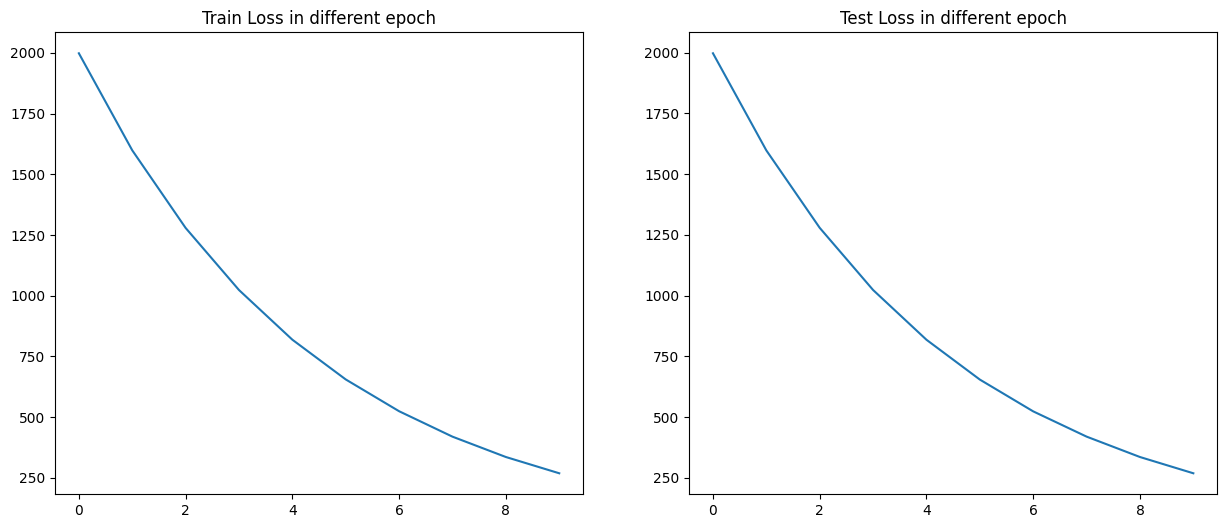

In [13]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(np.array([i for i in range(10)]), process_train)
plt.title('Train Loss in different epoch')

plt.subplot(1, 2, 2)
plt.plot(np.array([i for i in range(10)]), process_test)
plt.title('Test Loss in different epoch')

plt.show()

# Ex. 2 and Ex. 3 Neural Network

## Ex. 3

В начале я поясню, что я использовал для достижения конечной метрики 8.73. 

1) Во-первых, стоило обратить внимание на значени. Там наблюдались крупные выбросы, больше 100000 значений выходили за интервал трех дисперсий, что очевидно негативно сказывалось на конечной метрике. Поэтому, для улучшения результатов, я отбросил из обучающего датасета те строки, где хотя бы один из признаков выбивался за интервал 5.6 дисперсий.

2) Во-вторых, стоило определиться со слоями нейронной сети. Пробовались двух, трех и четырехслойные слои, четырехслойная дала наилучший результат. Были использованы стандартные линейные слои, ReLU и Dropout для предотвращения переобучения. Количество нейронов подбиралось так, чтобы сначала нейросеть моглас захватить большую часть основных тейков, а потом уже искала какие-то меньшие признаки, по которым можно выбрать год.

3) Для улучшения сходимости, таргет был стандартизирован и использовался для подсчета градиента в скалированном виде. Для подсчета RMSE, он, конечно, принимал обратную форму.

4) В качестве оптимизатора был выбран Adam за его быструю сходимость, однако из-за того, что вблизи минимума нужно делать меньшие шаги, был добавлен scheduler, который каждые 5 эпох уменьшает размер шага примерно в 2 раза.


Были и методы, которые не помогли:

1) Замена выбросов на "крайнее" значение т.е. выброс заменялся на M(column) + 5.6 * D(column)

2) RobustScaler вместо стандартизации основной таблицы. Предполагалось, что так масштаб будет более правильным, но, к сожалению, это не сработало

3) Использование SGD и AdamW оптимизаторов как основных, а также как вспомогательных (т. е. для продолжения движения, после достижения некоторого значений)

Очевидно, что при более тщательном подборе гиперпараметров можно было бы получить метрики выше, но что имеем.

Неудачные эксперементы будут после успешной реализации:

## Ex. 2

In [14]:
mask_train = pd.DataFrame(X_train)[(np.abs(stats.zscore(X_train)) < 5.6).all(axis=1)].index
X_train = pd.DataFrame(X_train).iloc[mask_train, :].to_numpy()
y_train = pd.DataFrame(y_train).iloc[mask_train, :].to_numpy()

In [15]:
#Реализуем наш класс для хранения датасета

class MusicDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        set_random_seed(main_random_state)
        self.data = torch.Tensor(X.astype(np.float32))
        self.y = torch.Tensor(y.astype(np.float32))
        self.n_samples = self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [16]:
#Реализуем нейронную сеть

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        set_random_seed(main_random_state)
        self.layers = nn.Sequential(
            nn.Linear(90, 100),
            nn.ReLU(),
            nn.Dropout(0.181),

            nn.Linear(100, 65),
            nn.ReLU(),
            nn.Dropout(0.181),

            nn.Linear(65, 40),
            nn.ReLU(),
            nn.Dropout(0.181),

            nn.Linear(40, 1)
        )

    def forward(self, X):
        return self.layers(X)

In [17]:
#Создадим и обучим скалер на таргете для более быстрой и качественной
#сходимости
scaler = StandardScaler()
scaler.fit(y_train.reshape(-1, 1))

#Создадим датасеты с отскалированным таргетом и из них даталодеры
train_set = MusicDataset(X_train, scaler.transform(y_train.reshape(-1, 1)).reshape(1, -1)[0])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

test_set = MusicDataset(X_test, scaler.transform(y_test.reshape(-1, 1)).reshape(1, -1)[0])
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

In [18]:
#Зададим базовые настройки (т.е. создадим объекты для функции обучения)
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.4)
criterion = nn.MSELoss()

In [19]:
def print_loss(model, optimizer, criterion, train_loader, test_loader, scaler, epoch, num_epoch):
    loss_train = 0
    loss_test = 0
    model.eval()
    for batch, target in train_loader:
        predictions = scaler.inverse_transform(model(batch).data.numpy())
        true_value = scaler.inverse_transform(target.data.numpy().reshape(-1, 1))
        loss_train += ((predictions - true_value) ** 2).sum()
    for batch, target in test_loader:
        predictions = scaler.inverse_transform(model(batch).data.numpy())
        true_value = scaler.inverse_transform(target.data.numpy().reshape(-1, 1))
        loss_test += ((predictions - true_value) ** 2).sum()
    print(f'Epoch [{epoch + 1}/{num_epoch}] \t Train RMSE: {math.sqrt(loss_train / 463715):.4f} \t', 
          f'Test RMSE: {math.sqrt(loss_test / 51630):.4f}')
    return math.sqrt(loss_train / 439926), math.sqrt(loss_test / 51630)

In [20]:
def train(model, optimizer, criterion, scheduler, train_loader, test_loader, scaler):
    #Зададим сид
    set_random_seed(main_random_state)

    #Опять два массива с "историей" ошибок
    loss_train_epoch = []
    loss_test_epoch = []

    
    #Обучим 12 эпохах
    for epoch in range(13):
        
            #Отметим train часть, далее стандартно сделаем предикт, посчитаем
            #градиент, сделаем шаг, обнулим градиент
            model.train()
            for batch, target in train_loader:
                predictions = model(batch)
                loss = criterion(predictions.view(1, -1)[0], target)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            #Будем иногда менять learning_rate для точности
            scheduler.step()

            #Валидационная часть, где мы посчитаем RMSE на всем датасете
            a, b = print_loss(model, optimizer, criterion, train_loader, test_loader, scaler, epoch, 13)
            loss_train_epoch.append(a)
            loss_test_epoch.append(b)
       
    return loss_train_epoch, loss_test_epoch

def test(model, criterion, test_loader):
    k = 0
    loss_test = 0
    predicts = np.array([])
    for batch, target in test_loader:
        k += batch.size()[0]
        predictions = scaler.inverse_transform(model(batch).data.numpy())
        true_value = scaler.inverse_transform(target.data.numpy().reshape(-1, 1))
        loss_test += ((predictions - true_value) ** 2).sum()
        predicts = np.append(predicts, predictions)
    print(f'Loss RMSE: {math.sqrt(loss_test / k)}')
    return predicts

In [21]:
loss_train, loss_test = train(model, optimizer, criterion, scheduler, train_loader, test_loader, scaler)

Epoch [1/13] 	 Train RMSE: 8.5041 	 Test RMSE: 8.9076
Epoch [2/13] 	 Train RMSE: 8.4178 	 Test RMSE: 8.8266
Epoch [3/13] 	 Train RMSE: 8.3622 	 Test RMSE: 8.7885
Epoch [4/13] 	 Train RMSE: 8.3210 	 Test RMSE: 8.8072
Epoch [5/13] 	 Train RMSE: 8.2480 	 Test RMSE: 8.7621
Epoch [6/13] 	 Train RMSE: 8.2065 	 Test RMSE: 8.7413
Epoch [7/13] 	 Train RMSE: 8.1757 	 Test RMSE: 8.7415
Epoch [8/13] 	 Train RMSE: 8.1665 	 Test RMSE: 8.7418
Epoch [9/13] 	 Train RMSE: 8.1341 	 Test RMSE: 8.7344
Epoch [10/13] 	 Train RMSE: 8.1187 	 Test RMSE: 8.7454
Epoch [11/13] 	 Train RMSE: 8.1055 	 Test RMSE: 8.7402
Epoch [12/13] 	 Train RMSE: 8.1071 	 Test RMSE: 8.7396
Epoch [13/13] 	 Train RMSE: 8.0923 	 Test RMSE: 8.7302


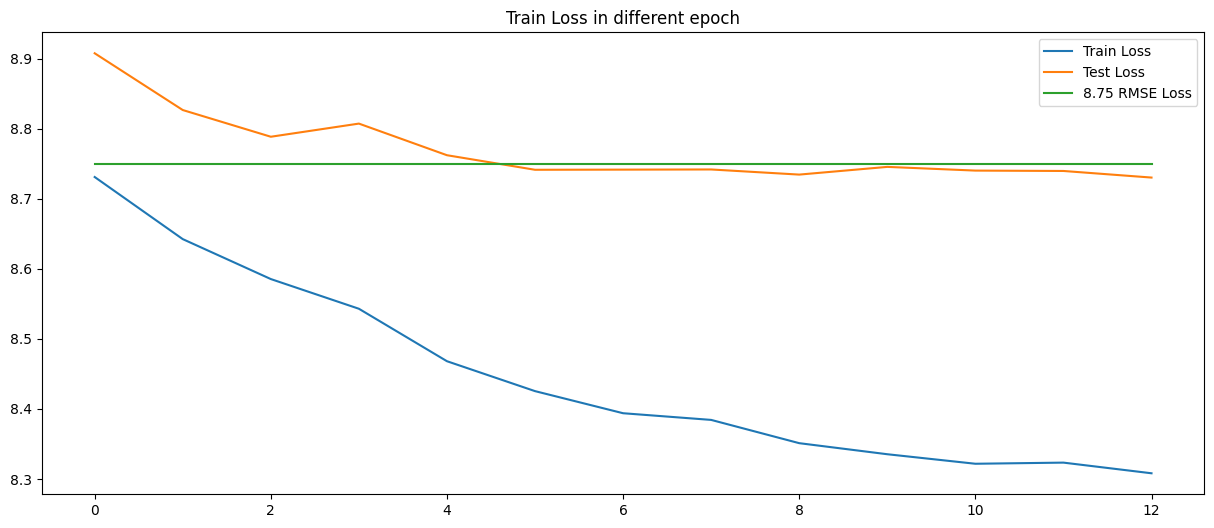

In [22]:
plt.figure(figsize=(15, 6))

plt.plot(np.array([i for i in range(13)]), loss_train, label='Train Loss')
plt.plot(np.array([i for i in range(13)]), loss_test, label='Test Loss')
plt.plot([0, 12], [8.75, 8.75], label='8.75 RMSE Loss')
plt.title('Train Loss in different epoch')
plt.legend()

plt.show()

In [23]:
test(model, criterion, test_loader)

Loss RMSE: 8.730210371681009


array([2004.50061035, 2001.06774902, 2004.44250488, ..., 1991.62939453,
       1999.01672363, 2004.46520996])

## Неудачные попытки

### Менее слойная архитектура

In [24]:
class NeuralNetwork_bad1(nn.Module):
    def __init__(self):
        super().__init__()
        set_random_seed(main_random_state)
        self.layers = nn.Sequential(
            nn.Linear(90, 60),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(60, 1)
        )

    def forward(self, X):
        return self.layers(X)

In [25]:
scaler = StandardScaler()
scaler.fit(y_train.reshape(-1, 1))

train_set = MusicDataset(X_train, scaler.transform(y_train.reshape(-1, 1)).reshape(1, -1)[0])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

test_set = MusicDataset(X_test, scaler.transform(y_test.reshape(-1, 1)).reshape(1, -1)[0])
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

In [26]:
model_bad1 = NeuralNetwork_bad1()
optimizer_bad1 = optim.Adam(model_bad1.parameters(), lr=1e-3)
scheduler_bad1 = torch.optim.lr_scheduler.StepLR(optimizer_bad1, step_size=4, gamma=0.4)
criterion_bad1 = nn.MSELoss()

In [27]:
train(model_bad1, optimizer_bad1, criterion_bad1, scheduler_bad1, train_loader, test_loader, scaler)

Epoch [1/13] 	 Train RMSE: 8.7162 	 Test RMSE: 9.0909
Epoch [2/13] 	 Train RMSE: 8.6486 	 Test RMSE: 9.0479
Epoch [3/13] 	 Train RMSE: 8.6303 	 Test RMSE: 9.0311
Epoch [4/13] 	 Train RMSE: 8.5718 	 Test RMSE: 8.9990
Epoch [5/13] 	 Train RMSE: 8.5263 	 Test RMSE: 8.9705
Epoch [6/13] 	 Train RMSE: 8.5185 	 Test RMSE: 8.9552
Epoch [7/13] 	 Train RMSE: 8.5032 	 Test RMSE: 8.9419
Epoch [8/13] 	 Train RMSE: 8.4959 	 Test RMSE: 8.9397
Epoch [9/13] 	 Train RMSE: 8.4822 	 Test RMSE: 8.9318
Epoch [10/13] 	 Train RMSE: 8.4744 	 Test RMSE: 8.9294
Epoch [11/13] 	 Train RMSE: 8.4703 	 Test RMSE: 8.9371
Epoch [12/13] 	 Train RMSE: 8.4679 	 Test RMSE: 8.9438
Epoch [13/13] 	 Train RMSE: 8.4616 	 Test RMSE: 8.9278


([8.948800156212183,
  8.879366103902669,
  8.860580783089713,
  8.800534984114899,
  8.753764125505072,
  8.745735546835139,
  8.730074889592212,
  8.722615071888812,
  8.708547458225459,
  8.700539848743052,
  8.696349138870168,
  8.69387559523436,
  8.687395095334484],
 [9.090897539013204,
  9.047894447942761,
  9.031088724938222,
  8.998968397742821,
  8.970541973885908,
  8.955179536437088,
  8.941907759023472,
  8.939712073782262,
  8.931828134033577,
  8.929362484757805,
  8.937106055860351,
  8.94380646699335,
  8.927811401450445])

### Использование иных оптимизатора и scheduler

In [28]:
class NeuralNetwork_bad2(nn.Module):
    def __init__(self):
        super().__init__()
        set_random_seed(main_random_state)
        self.layers = nn.Sequential(
            nn.Linear(90, 100),
            nn.ReLU(),
            nn.Dropout(0.181),

            nn.Linear(100, 65),
            nn.ReLU(),
            nn.Dropout(0.181),

            nn.Linear(65, 40),
            nn.ReLU(),
            nn.Dropout(0.181),

            nn.Linear(40, 1)
        )

    def forward(self, X):
        return self.layers(X)

In [29]:
scaler = StandardScaler()
scaler.fit(y_train.reshape(-1, 1))

train_set = MusicDataset(X_train, scaler.transform(y_train.reshape(-1, 1)).reshape(1, -1)[0])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

test_set = MusicDataset(X_test, scaler.transform(y_test.reshape(-1, 1)).reshape(1, -1)[0])
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

In [30]:
model_bad2 = NeuralNetwork_bad2()
optimizer_bad2 = optim.SGD(model_bad2.parameters(), lr=1e-3)
scheduler_bad2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_bad2, T_max=20, eta_min=0.00001)
criterion_bad2 = nn.MSELoss()

In [31]:
train(model_bad2, optimizer_bad2, criterion_bad2, scheduler_bad2, train_loader, test_loader, scaler)

Epoch [1/13] 	 Train RMSE: 10.6176 	 Test RMSE: 10.7822
Epoch [2/13] 	 Train RMSE: 10.5087 	 Test RMSE: 10.6692
Epoch [3/13] 	 Train RMSE: 10.2867 	 Test RMSE: 10.4523
Epoch [4/13] 	 Train RMSE: 9.9821 	 Test RMSE: 10.1804
Epoch [5/13] 	 Train RMSE: 9.7353 	 Test RMSE: 9.9777
Epoch [6/13] 	 Train RMSE: 9.5586 	 Test RMSE: 9.8306
Epoch [7/13] 	 Train RMSE: 9.4274 	 Test RMSE: 9.7185
Epoch [8/13] 	 Train RMSE: 9.3274 	 Test RMSE: 9.6299
Epoch [9/13] 	 Train RMSE: 9.2513 	 Test RMSE: 9.5615
Epoch [10/13] 	 Train RMSE: 9.1946 	 Test RMSE: 9.5066
Epoch [11/13] 	 Train RMSE: 9.1516 	 Test RMSE: 9.4650
Epoch [12/13] 	 Train RMSE: 9.1196 	 Test RMSE: 9.4340
Epoch [13/13] 	 Train RMSE: 9.0952 	 Test RMSE: 9.4107


([10.900875217188718,
  10.78912594634086,
  10.561168100688281,
  10.24843649046987,
  9.995040126858495,
  9.81361809310264,
  9.678949888160199,
  9.57622743573717,
  9.49818960895812,
  9.439977319711447,
  9.395741666419477,
  9.36296245404341,
  9.337864846566093],
 [10.782199164457449,
  10.669190928280265,
  10.452338958142969,
  10.18039483485289,
  9.977731907489819,
  9.830646080340529,
  9.718547556095363,
  9.62994796347679,
  9.561455025392393,
  9.506622790580485,
  9.46497831372197,
  9.433991452516075,
  9.410698228905101])

Как видим, в обоих экспериментах исход был неудачным

# Ex. 4 Classification 

## Нейронная сеть и базовые преобразования

In [44]:
#Еще раз запишем X_train и остальные данные
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [45]:
#Отскалируем
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
#Реализация нейронной сети для классификации. Используем здесь и Softmax в силу специфики задачи.

class ClassificationNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        set_random_seed(main_random_state)
        self.layers = nn.Sequential(
            nn.Linear(90, 120),
            nn.Softmax(),

            nn.Linear(120, 100),
            nn.ReLU(),

            nn.Linear(100, 89),
        )

    def forward(self, X):
        return self.layers(X)

In [47]:
def train_classification(model, optimizer, criterion, train_loader, test_loader):
    set_random_seed(main_random_state)
    for epoch in range(5):
            model.train()
            for batch, target in train_loader:
                predictions = model(batch)
                loss = criterion(predictions, target.long())
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            scheduler.step()
            loss_train = np.array([])
            loss_test = np.array([])
            
            model.eval()
            for batch, target in train_loader:
                predictions = model(batch)
                _, predictions = torch.max(predictions, 1)
                loss_train = np.append(loss_train, predictions)
            for batch, target in test_loader:
                predictions = model(batch)
                _, predictions = torch.max(predictions, 1)
                loss_test = np.append(loss_test, predictions)
            print(f'Epoch [{epoch + 1}/{100}] \t Train accuracy: {accuracy_score(train_loader.dataset.y.numpy(), loss_train):.4f} ',
                  'Train f1 score: ', f1_score(loss_train, train_loader.dataset.y.numpy(), average='weighted'))
            print(f'Epoch [{epoch + 1}/{100}] \t  Test accuracy: {accuracy_score(test_loader.dataset.y.numpy(), loss_test):.4f} ',
                  'Test f1 score:  ', f1_score(loss_test, test_loader.dataset.y.numpy(), average='weighted'))
            print('\n')

In [48]:
def test_classification(model, criterion, test_loader):
    predicts = np.array([])
    for batch, target in train_loader:
        predictions = model(batch)
        _, predictions = torch.max(predictions, 1)
        predicts = np.append(predicts, predictions)
    return predicts

## Один год - один класс

In [49]:
#Создадим даталодеры с закодированными лейблом целевыми данными
enc = LabelEncoder()
enc.fit(y_train)

train_set_for_class1 = MusicDataset(X_train, enc.transform(y_train))
train_loader_for_class1 = DataLoader(train_set_for_class1, batch_size=1024, shuffle=True)

test_set_for_class1 = MusicDataset(X_test, enc.transform(y_test))
test_loader_for_class1 = DataLoader(test_set_for_class1, batch_size=1024, shuffle=True)

In [50]:
model_for_class1 = ClassificationNeuralNetwork()
optimizer_for_class1 = optim.Adam(model_for_class1.parameters(), lr=1e-5)
scheduler_for_class1 = torch.optim.lr_scheduler.StepLR(optimizer_for_class1, step_size=7, gamma=0.5)
criterion_for_class1 = nn.CrossEntropyLoss()

In [51]:
train_classification(model_for_class1, optimizer_for_class1, criterion_for_class1, train_loader_for_class1, test_loader_for_class1)

Epoch [1/100] 	 Train accuracy: 0.0338  Train f1 score:  0.05795012090235759
Epoch [1/100] 	  Test accuracy: 0.0336  Test f1 score:   0.057222704830638224


Epoch [2/100] 	 Train accuracy: 0.0762  Train f1 score:  0.1416005629969624
Epoch [2/100] 	  Test accuracy: 0.0780  Test f1 score:   0.14462217454549306


Epoch [3/100] 	 Train accuracy: 0.0763  Train f1 score:  0.14171119304131016
Epoch [3/100] 	  Test accuracy: 0.0780  Test f1 score:   0.14473606124737043


Epoch [4/100] 	 Train accuracy: 0.0763  Train f1 score:  0.14174092680986144
Epoch [4/100] 	  Test accuracy: 0.0780  Test f1 score:   0.14477382104079706


Epoch [5/100] 	 Train accuracy: 0.0763  Train f1 score:  0.141749118241796
Epoch [5/100] 	  Test accuracy: 0.0780  Test f1 score:   0.14477402403826534




## Биннинг на 10 классов по десятилетиям

In [52]:
train_set_for_class2 = MusicDataset(X_train, pd.cut(pd.DataFrame(y_train)[0], bins=10, labels=[i for i in range(10)]).to_numpy())
train_loader_for_class2 = DataLoader(train_set_for_class2, batch_size=1024, shuffle=True)

test_set_for_class2 = MusicDataset(X_test, pd.cut(pd.DataFrame(y_test)[0], bins=10, labels=[i for i in range(10)]).to_numpy())
test_loader_for_class2 = DataLoader(test_set_for_class2, batch_size=1024, shuffle=True)

In [53]:
model_for_class2 = ClassificationNeuralNetwork()
optimizer_for_class2 = optim.Adam(model_for_class2.parameters(), lr=1e-5)
scheduler_for_class2 = torch.optim.lr_scheduler.StepLR(optimizer_for_class2, step_size=7, gamma=0.5)
criterion_for_class2 = nn.CrossEntropyLoss()

In [54]:
train_classification(model_for_class2, optimizer_for_class2, criterion_for_class2, train_loader_for_class2, test_loader_for_class2)

Epoch [1/100] 	 Train accuracy: 0.2967  Train f1 score:  0.4574081032577858
Epoch [1/100] 	  Test accuracy: 0.2565  Test f1 score:   0.4082306412330091


Epoch [2/100] 	 Train accuracy: 0.2968  Train f1 score:  0.4577798119430241
Epoch [2/100] 	  Test accuracy: 0.2566  Test f1 score:   0.40841698492155903


Epoch [3/100] 	 Train accuracy: 0.2969  Train f1 score:  0.45778973150613406
Epoch [3/100] 	  Test accuracy: 0.2566  Test f1 score:   0.408353728626576


Epoch [4/100] 	 Train accuracy: 0.2969  Train f1 score:  0.45767711941854117
Epoch [4/100] 	  Test accuracy: 0.2566  Test f1 score:   0.40831808539736286


Epoch [5/100] 	 Train accuracy: 0.2970  Train f1 score:  0.4572811671097345
Epoch [5/100] 	  Test accuracy: 0.2568  Test f1 score:   0.4079869399441909




Честное слово, я на 10 эпохах прогонял,качество до 0.6 растет, время поджимает, поэтому перепрогнал на 5

## Биннинг на 10 классов по квартилям

In [55]:
train_set_for_class3 = MusicDataset(X_train, pd.qcut(pd.DataFrame(y_train)[0], q=10, labels=[i for i in range(10)]).to_numpy())
train_loader_for_class3 = DataLoader(train_set_for_class3, batch_size=1024, shuffle=True)

test_set_for_class3 = MusicDataset(X_test, pd.qcut(pd.DataFrame(y_test)[0], q=10, labels=[i for i in range(10)]).to_numpy())
test_loader_for_class3 = DataLoader(test_set_for_class3, batch_size=1024, shuffle=True)

In [56]:
model_for_class3 = ClassificationNeuralNetwork()
optimizer_for_class3 = optim.Adam(model_for_class3.parameters(), lr=1e-5)
scheduler_for_class3 = torch.optim.lr_scheduler.StepLR(optimizer_for_class3, step_size=7, gamma=0.5)
criterion_for_class3 = nn.CrossEntropyLoss()

In [ ]:
train_classification(model_for_class3, optimizer_for_class3, criterion_for_class3, train_loader_for_class3, test_loader_for_class3)

Epoch [1/100] 	 Train accuracy: 0.0675  Train f1 score:  0.1258568620659113
Epoch [1/100] 	  Test accuracy: 0.0680  Test f1 score:   0.12702953300361083


Epoch [2/100] 	 Train accuracy: 0.0709  Train f1 score:  0.12307568256233539
Epoch [2/100] 	  Test accuracy: 0.0719  Test f1 score:   0.12483726684356641


Epoch [3/100] 	 Train accuracy: 0.1223  Train f1 score:  0.21304092808697778
Epoch [3/100] 	  Test accuracy: 0.1184  Test f1 score:   0.20673211098051758


Epoch [4/100] 	 Train accuracy: 0.1247  Train f1 score:  0.22052913394937143
Epoch [4/100] 	  Test accuracy: 0.1210  Test f1 score:   0.2147238009331231




Как видим, биннинг дает намного более хорошие результаты, чем присваивание каждому году отдельный класс. Это вполне очевидно: это связано и с балансом классов, который во втором случае намного хуже, и с логикой (намного проще определить десятилетие, чем конкретный год). Также видно, что биннинг по квартилям дал не очень хороший результат (опять же логично - нам даны в основном данные о новой музыке, а значит классы 2000, 2005, 2007 итп будут попадать в один класс, а определить класс на таком маленьком временном промежутке сложнее,чем в десятилетии). Если сравнивать эту задачу с задачей регрессии, то мы видим, что оба подхода здесь достаточно хорошо справляются, однако на мой взгляд, для определения года выпуска музыки больше подойдет классификация т.к. схожесть музыки определяется трендом и модой, а значит нам достаточно определить временной промежуток, когда она была сделана. Хотя здесь скорее стоит брать биннинг по пятилеткам.